In [1]:
import numpy as np
import cv2
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout,SpatialDropout2D
from keras.models  import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import random,os,glob
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

In [2]:
dir_path = 'F:/UWL Study Documents/Dissertation/Dataset3/Garbage classification/Garbage classification'

In [3]:
img_list = glob.glob(os.path.join(dir_path, '*/*.jpg'))

In [4]:
len(img_list)

2527

Image Augmentation

In [5]:
train=ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

test=ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)

train_generator=train.flow_from_directory(dir_path,
                                          target_size=(300,300),
                                          batch_size=32,
                                          class_mode='categorical',
                                          subset='training')

test_generator=test.flow_from_directory(dir_path,
                                        target_size=(300,300),
                                        batch_size=32,
                                        class_mode='categorical',
                                        subset='validation')

labels = (train_generator.class_indices)
print(labels)

labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [6]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 300, 300, 3), (32, 6))

Writing the labels file

In [7]:
print (train_generator.class_indices)

Labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(Labels)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


Building CNN & Saving keras model

In [8]:
model=Sequential()
#Convolution blocks

model.add(Conv2D(32,(3,3), padding='same',input_shape=(300,300,3),activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 
#model.add(SpatialDropout2D(0.5)) # No accuracy

model.add(Conv2D(64,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 
#model.add(SpatialDropout2D(0.5))

model.add(Conv2D(32,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 

#Classification layers
model.add(Flatten())

model.add(Dense(64,activation='relu'))
#model.add(SpatialDropout2D(0.5))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

filepath="trained_model.h5"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]

Summarizing our model

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 37, 37, 32)        0

Using Tensorflow

In [10]:
from tensorflow.keras.callbacks import TensorBoard

In [11]:
# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='F:/UWL Study Documents/Dissertation/Dataset2_Logs', histogram_freq=1)

Compiling Model using categorical cross entropy loss function & Adam Optimizer

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc']) # RMS PROP - No accuracy

#es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

Training

In [13]:
history = model.fit_generator(train_generator,
                              epochs=100,
                              steps_per_epoch=2276//32,
                              validation_data=test_generator,
                              validation_steps=251//32,
                              workers = 4,
                              callbacks=[callbacks_list, tensorboard_callback]) 

C:\Users\123456\AppData\Local\Temp\ipykernel_10344\3060681096.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/100
71/71 [==============================] - ETA: 0s - loss: 1.6262 - acc: 0.3209
Epoch 1: val_acc improved from -inf to 0.46429, saving model to trained_model.h5


C:\ProgramData\Anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


71/71 [==============================] - 283s 4s/step - loss: 1.6262 - acc: 0.3209 - val_loss: 1.3926 - val_acc: 0.4643
Epoch 2/100
71/71 [==============================] - ETA: 0s - loss: 1.4734 - acc: 0.3988
Epoch 2: val_acc did not improve from 0.46429
71/71 [==============================] - 265s 4s/step - loss: 1.4734 - acc: 0.3988 - val_loss: 1.4593 - val_acc: 0.4196
Epoch 3/100
71/71 [==============================] - ETA: 0s - loss: 1.3728 - acc: 0.4483
Epoch 3: val_acc improved from 0.46429 to 0.47321, saving model to trained_model.h5
71/71 [==============================] - 269s 4s/step - loss: 1.3728 - acc: 0.4483 - val_loss: 1.3678 - val_acc: 0.4732
Epoch 4/100
71/71 [==============================] - ETA: 0s - loss: 1.3356 - acc: 0.4675
Epoch 4: val_acc improved from 0.47321 to 0.47768, saving model to trained_model.h5
71/71 [==============================] - 263s 4s/step - loss: 1.3356 - acc: 0.4675 - val_loss: 1.3019 - val_acc: 0.4777
Epoch 5/100
71/71 [=================

Testing Prediction

1/1 [==============================] - 10s 10s/step
Maximum Probability:  0.9997991
Classified: plastic


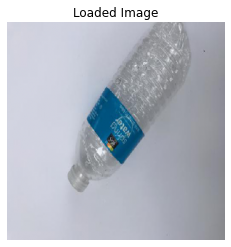

In [14]:
from keras.preprocessing import image

img_path = 'F:/UWL Study Documents/Dissertation/ds2_test_img.jpg'

img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)


-------------------Individual Probability--------------------------------

CARDBOARD : 0.0 %
GLASS : 0.02 %
METAL : 0.0 %
PAPER : 0.0 %
PLASTIC : 99.98 %
TRASH : 0.0 %


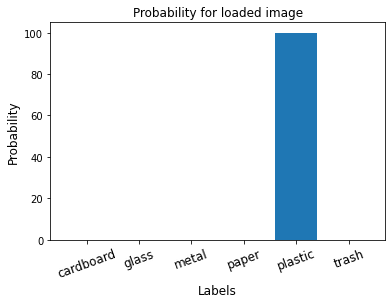

In [15]:
classes=[]
prob=[]
print("\n-------------------Individual Probability--------------------------------\n")

for i,j in enumerate (p[0],0):
    print(labels[i].upper(),':',round(j*100,2),'%')
    classes.append(labels[i])
    prob.append(round(j*100,2))
    
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(classes))
    plt.bar(index, prob)
    plt.xlabel('Labels', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.xticks(index, classes, fontsize=12, rotation=20)
    plt.title('Probability for loaded image')
    plt.show()
plot_bar_x()

Accuracy Graph

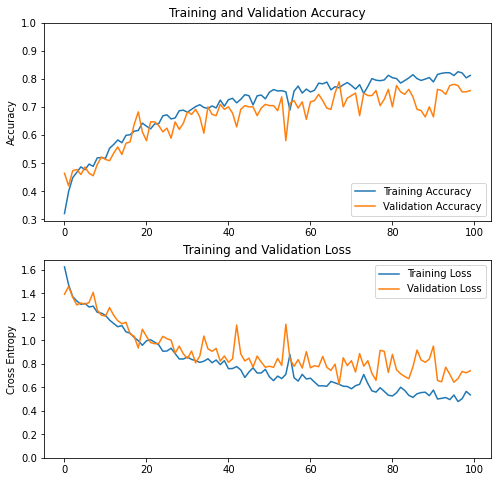

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

Converting to TFLite

In [17]:
file = "Garbage.h5"
keras.models.save_model(model, file)

# Load the Keras model
loaded_model = keras.models.load_model(file)

# Convert the Keras model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
open("garbage.tflite", "wb").write(tflite_model)

C:\Users\123456\AppData\Local\Temp\ipykernel_10344\686263609.py:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model, file)


INFO:tensorflow:Assets written to: C:\Users\123456\AppData\Local\Temp\tmp2zbh2e7d\assets


INFO:tensorflow:Assets written to: C:\Users\123456\AppData\Local\Temp\tmp2zbh2e7d\assets


11380140

# Random Forest and KNN

In [18]:
# Load a pre-trained deep learning model (VGG16)
base_model = VGG16(weights='imagenet', include_top=False)

In [19]:
# Function to extract features from an image
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    return features.flatten()

In [20]:
# Load your dataset and extract features
dir_path = 'F:/UWL Study Documents/Dissertation/Dataset3/Garbage classification/Garbage classification'
img_list = glob.glob(os.path.join(dir_path, '*/*.jpg'))
X = [extract_features(img_path, base_model) for img_path in img_list]

1/1 [==============================] - 0s 391ms/step


In [21]:
# Extract class labels from the image file paths
y = [os.path.basename(os.path.dirname(img_path)) for img_path in img_list]

In [22]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [24]:
# Make predictions on the test set
rf_predictions = rf_classifier.predict(X_test)

In [25]:
# Evaluate the Random Forest model
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)
print(classification_report(y_test, rf_predictions))

Random Forest Accuracy: 0.7549407114624506
              precision    recall  f1-score   support

   cardboard       0.95      0.85      0.90        71
       glass       0.69      0.74      0.71       107
       metal       0.76      0.59      0.66        87
       paper       0.74      0.97      0.84       118
     plastic       0.71      0.73      0.72        99
       trash       1.00      0.21      0.34        24

    accuracy                           0.75       506
   macro avg       0.81      0.68      0.70       506
weighted avg       0.77      0.75      0.74       506



In [26]:
# K-Nearest Neighbors Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [27]:
# Make predictions on the test set
knn_predictions = knn_classifier.predict(X_test)

In [28]:
# Evaluate the KNN model
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("K-Nearest Neighbors Accuracy:", knn_accuracy)
print(classification_report(y_test, knn_predictions))

K-Nearest Neighbors Accuracy: 0.5098814229249012
              precision    recall  f1-score   support

   cardboard       0.87      0.58      0.69        71
       glass       0.52      0.62      0.56       107
       metal       0.77      0.11      0.20        87
       paper       0.57      0.67      0.62       118
     plastic       0.35      0.63      0.45        99
       trash       0.00      0.00      0.00        24

    accuracy                           0.51       506
   macro avg       0.51      0.43      0.42       506
weighted avg       0.57      0.51      0.48       506



In [29]:
# Function to plot a confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

In [30]:
# Obtain unique class labels from your dataset
unique_labels = np.unique(np.concatenate((y_test, knn_predictions, rf_predictions)))

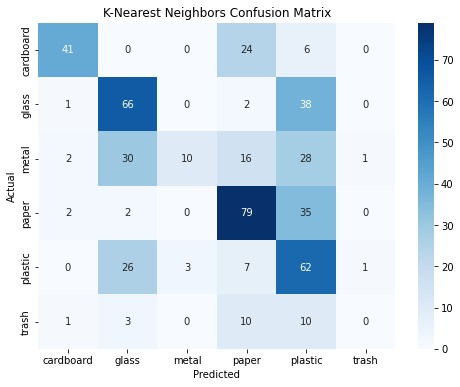

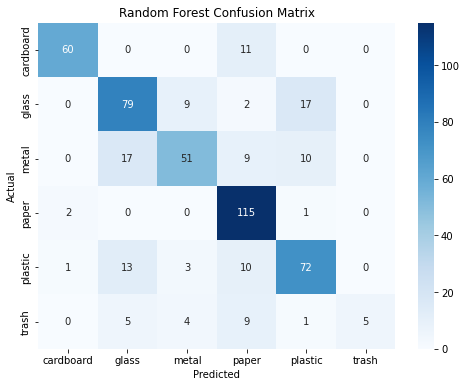

In [31]:
# K-Nearest Neighbors Confusion Matrix
plot_confusion_matrix(y_test, knn_predictions, labels=unique_labels, title='K-Nearest Neighbors Confusion Matrix')

# Random Forest Confusion Matrix
plot_confusion_matrix(y_test, rf_predictions, labels=unique_labels, title='Random Forest Confusion Matrix')

Function to test predictions

In [32]:
# Function to test predictions
def test_predictions(classifier, model, img_path):
    # Extract features from the input image
    features = extract_features(img_path, model)

    # Make predictions using the classifier
    predicted_class = classifier.predict([features])

    return predicted_class[0]

In [33]:
#Image path to test predictions
test_img_path = 'F:/UWL Study Documents/Dissertation/ds2_test_img.jpg'

In [34]:
# Test K-Nearest Neighbors prediction
knn_prediction = test_predictions(knn_classifier, base_model, test_img_path)
print("K-Nearest Neighbors Prediction:", knn_prediction)

1/1 [==============================] - 0s 407ms/step
K-Nearest Neighbors Prediction: plastic


In [35]:
# Test Random Forest prediction
rf_prediction = test_predictions(rf_classifier, base_model, test_img_path)
print("Random Forest Prediction:", rf_prediction)

1/1 [==============================] - 0s 375ms/step
Random Forest Prediction: plastic


Second Prediction

Testing using cnn

1/1 [==============================] - 0s 285ms/step
Maximum Probability:  0.46717775
Classified: plastic


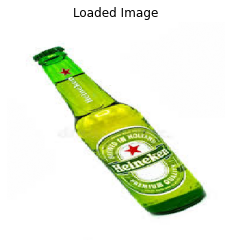

In [36]:
from keras.preprocessing import image

img_path = 'F:/UWL Study Documents/Dissertation/ds2_test_img2.jpg'

img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)

Testing using Knn

In [37]:
#Image path to test predictions
test_img_path = 'F:/UWL Study Documents/Dissertation/ds2_test_img2.jpg'

In [38]:
# Test K-Nearest Neighbors prediction
knn_prediction = test_predictions(knn_classifier, base_model, test_img_path)
print("K-Nearest Neighbors Prediction:", knn_prediction)

1/1 [==============================] - 1s 606ms/step
K-Nearest Neighbors Prediction: glass


Testing using Random Forest

In [39]:
# Test Random Forest prediction
rf_prediction = test_predictions(rf_classifier, base_model, test_img_path)
print("Random Forest Prediction:", rf_prediction)

1/1 [==============================] - 1s 669ms/step
Random Forest Prediction: glass
